# Customer Churn Prediction in Telecom

## Machine Learning Case Study

This project focuses on predicting customer churn in the telecom domain using classical machine learning techniques.
The goal is to identify customers likely to churn so that retention strategies can be applied proactively.

The project covers:
- Data cleaning and feature selection
- Feature engineering using domain knowledge
- Model building and evaluation
- Business-driven metric selection


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')


## Dataset Loading

The telecom customer churn dataset contains customer demographics, service usage,
billing information, and churn labels.


In [3]:
df = pd.read_csv("telco.csv")
df.head()


,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,20,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,0,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,0,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,0,494.00,2995.07,2,Churned,Yes,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,0,234.21,3102.36,2,Churned,Yes,67,2793,Price,Extra data charges


In [4]:
df.shape


(7043, 50)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Under 30                           7043 non-null   object 
 4   Senior Citizen                     7043 non-null   object 
 5   Married                            7043 non-null   object 
 6   Dependents                         7043 non-null   object 
 7   Number of Dependents               7043 non-null   int64  
 8   Country                            7043 non-null   object 
 9   State                              7043 non-null   object 
 10  City                               7043 non-null   object 
 11  Zip Code                           7043 non-null   int64

## Feature Selection

Columns causing data leakage, identifiers, and post-churn information are removed.
This ensures that the model is trained only on information available before churn occurs.


In [6]:
drop_cols = [
    'Customer ID', 'Country', 'State', 'City', 'Zip Code',
    'Latitude', 'Longitude', 'Population', 'Quarter',
    'Customer Status', 'Churn Score', 'Churn Category',
    'Churn Reason', 'CLTV', 'Total Revenue',
    'Satisfaction Score', 'Age', 'Under 30',
    'Streaming Music', 'Avg Monthly GB Download',
    'Avg Monthly Long Distance Charges', 'Total Refunds',
    'Total Extra Data Charges', 'Total Long Distance Charges',
    'Offer'
]

df.drop(columns=drop_cols, inplace=True)
df.shape


(7043, 25)

## Exploratory Data Analysis (EDA)

EDA is performed to understand customer behavior patterns and identify
factors associated with churn. This analysis guides feature engineering
and model selection decisions.


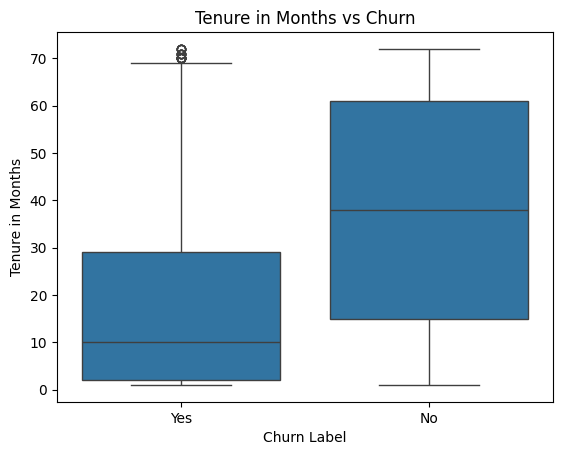

In [13]:
sns.boxplot(x='Churn Label', y='Tenure in Months', data=df)
plt.title("Tenure in Months vs Churn")
plt.show()


The box plot shows that customers who churn typically have much lower tenure compared to customers who stay.
The median tenure for churned customers is around 10 months, whereas non-churned customers have a median tenure of nearly 40 months.
This indicates that churn risk is highest during the early stages of the customer lifecycle.


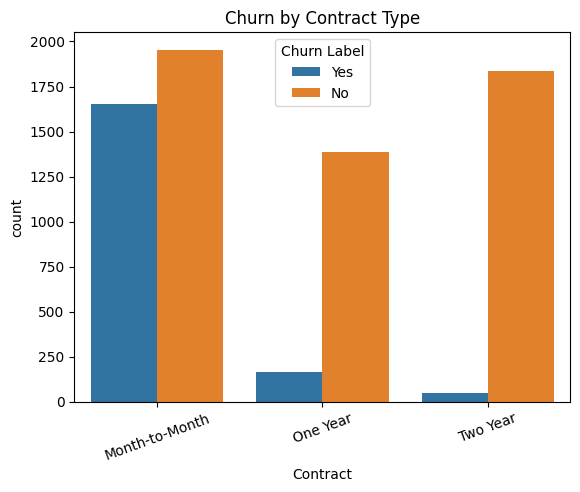

In [14]:
sns.countplot(x='Contract', hue='Churn Label', data=df)
plt.xticks(rotation=20)
plt.title("Churn by Contract Type")
plt.show()


The plot shows a strong relationship between contract duration and customer churn.
Customers on month-to-month contracts have the highest churn rates, while customers on one-year and two-year contracts are significantly more likely to stay.
This indicates that longer contract commitments reduce churn risk.

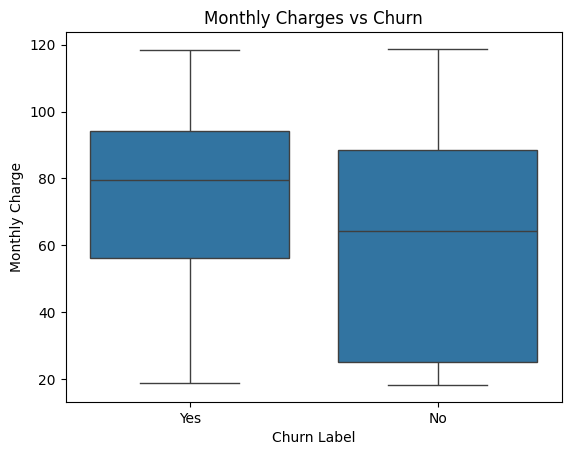

In [15]:
sns.boxplot(x='Churn Label', y='Monthly Charge', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()


The box plot shows that customers who churn tend to have higher monthly charges compared to customers who stay.


## Feature Engineering

New features are created to capture customer lifecycle, pricing pressure,
and service engagement using domain knowledge.


In [9]:
# Customer lifecycle grouping
df['Tenure_Group'] = pd.cut(
    df['Tenure in Months'],
    bins=[0, 12, 24, 48, 72],
    labels=['0-1 year', '1-2 years', '2-4 years', '4-6 years']
)

# Normalized pricing
df['Avg_Charge_Per_Month'] = df['Total Charges'] / (df['Tenure in Months'] + 1)

# Customer engagement
service_cols = [
    'Phone Service', 'Multiple Lines', 'Internet Service',
    'Online Security', 'Online Backup', 'Device Protection Plan',
    'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
    'Unlimited Data'
]

df['Service_Count'] = df[service_cols].apply(
    lambda x: (x == 'Yes').sum(),
    axis=1
)

# High monthly charge risk flag
df['High_Monthly_Charge'] = (
    df['Monthly Charge'] > df['Monthly Charge'].median()
).astype(int)


In [10]:
df[['Tenure_Group', 'Avg_Charge_Per_Month',
    'Service_Count', 'High_Monthly_Charge']].head()


,Tenure_Group,Avg_Charge_Per_Month,Service_Count,High_Monthly_Charge
0,0-1 year,19.825000,3,0
1,0-1 year,70.366667,5,1
2,1-2 years,92.239474,6,1
3,2-4 years,96.711538,7,1
4,2-4 years,75.477632,4,1


## Target Variable Distribution

The dataset is moderately imbalanced, making recall an important metric for churn prediction.


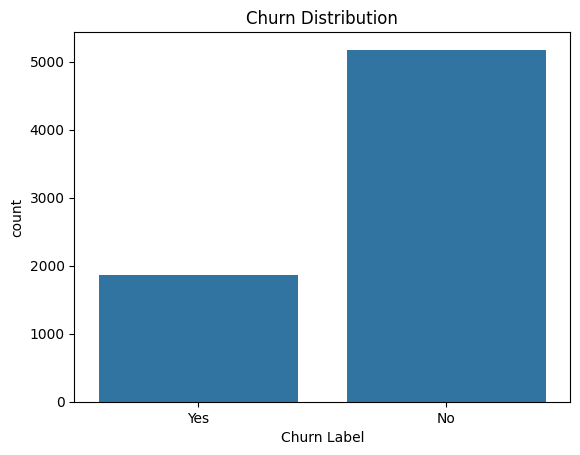

In [12]:
sns.countplot(x='Churn Label', data=df)
plt.title("Churn Distribution")
plt.show()


The dataset shows moderate class imbalance, with approximately 73% non-churn customers and 27% churn customers.
This indicates that accuracy alone may be misleading, and metrics such as recall and F1-score are important for evaluation.

In [16]:
X = df.drop('Churn Label', axis=1)
y = df['Churn Label'].map({'Yes': 1, 'No': 0})

X.shape, y.shape


((7043, 28), (7043,))

## Categorical Encoding

Categorical variables are converted to numerical form using one-hot encoding.
Both object and category dtypes are encoded.


In [17]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

X_encoded = pd.get_dummies(
    X,
    columns=cat_cols,
    drop_first=True
)

X_encoded.shape


(7043, 33)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Feature Scaling

Scaling is applied only for Logistic Regression.
Tree-based models do not require scaling.


In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Logistic Regression

Used as a baseline model due to its simplicity and interpretability.


In [20]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print(classification_report(y_test, y_pred_lr))
confusion_matrix(y_test, y_pred_lr)


              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1035
           1       0.75      0.67      0.70       374

    accuracy                           0.85      1409
   macro avg       0.81      0.79      0.80      1409
weighted avg       0.85      0.85      0.85      1409



array([[950,  85],
       [125, 249]])

### Logistic Regression Evaluation

The Logistic Regression model achieved an overall accuracy of 85%.
For churn prediction (class 1), the model obtained a recall of 67%, indicating that it correctly identified 67% of customers who churned.

While the model performs well in predicting non-churn customers, it misses some churn cases, suggesting a trade-off between precision and recall.
This model serves as a strong and interpretable baseline for comparison with more complex models.


## Random Forest

A non-linear ensemble model used to capture complex feature interactions.


In [21]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1035
           1       0.73      0.61      0.66       374

    accuracy                           0.84      1409
   macro avg       0.80      0.76      0.78      1409
weighted avg       0.83      0.84      0.83      1409



### Random Forest Evaluation (Baseline)

The Random Forest model achieved an accuracy of 84%.
For churn prediction (class 1), the model obtained a recall of 61%, indicating that it identified fewer churn customers compared to Logistic Regression.

Although Random Forest performed well in predicting non-churn customers, its lower recall for churn suggests that the default model configuration favors the majority class.
This highlights the need for model tuning to better align performance with business objectives.


## Tuned Random Forest

The model is tuned to improve recall for churn customers,
prioritizing business impact over accuracy.


In [22]:
rf_tuned = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=20,
    class_weight={0: 1, 1: 2},
    random_state=42
)

rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test)

print(classification_report(y_test, y_pred_rf_tuned))
confusion_matrix(y_test, y_pred_rf_tuned)


              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1035
           1       0.66      0.75      0.70       374

    accuracy                           0.83      1409
   macro avg       0.78      0.81      0.79      1409
weighted avg       0.84      0.83      0.84      1409



array([[891, 144],
       [ 93, 281]])

## Conclusion

- Feature engineering significantly improved churn signal quality
- Logistic Regression provided a strong baseline
- Tuned Random Forest achieved higher recall for churn customers
- The project demonstrates an end-to-end machine learning workflow
  with business-driven evaluation
